# Project 1 
#### by Fabio, Ivan and Olivier

## Data Import

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import *

# Loading the training data
y, tX, ids = load_csv_data('data/train.csv')

## Data Preprocessing

### Undefined values visualization

In [9]:
# LaTeX Typesetting
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{eulervm}',
    'font.family': 'serif',
    'font.serif': 'Palatino',
    'font.size': 11,
})

cm = 1/2.54  # Convert centimeters to inches
color_theme = '#2171b5'  # Color definition

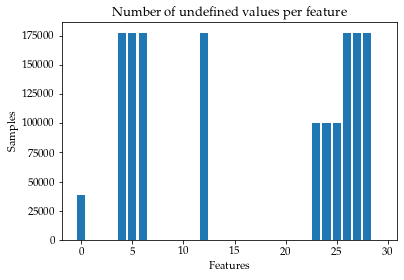

Percentage of inputs with at least one undefined feature:  72.7544


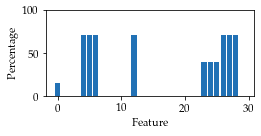

In [22]:
#Counting the number of undefined values and the percentage of undefined values
counter = np.sum((tX == -999), axis = 0)
undef_ind = np.nonzero(counter)[0]
plt.bar(np.arange(len(counter)), counter)
plt.title("Number of undefined values per feature") 
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

#Percentage of undefined values
plt.figure(figsize=(9.5*cm, 4*cm))
N = tX.shape[0]
rel_counter = counter / N * 100
plt.bar(np.arange(len(rel_counter)), rel_counter, color=color_theme)
#plt.title("Percentage of undefined values per feature") 
plt.xlabel('Feature')
plt.ylabel('Percentage')
plt.ylim([0, 100])
plt.savefig('report/figures/undefined_values.pgf', bbox_inches='tight')


#Counting the percentage of inputs with at least one undefined feature 
counter = np.sum((tX == -999), axis = 1)
tot = np.count_nonzero(counter)
print("Percentage of inputs with at least one undefined feature: ", tot / N * 100)

Notes:
* Same number of undefined features for some features. This are structurally missing features.
* Very high percentage for some particular features.

### Dataset splitting

In [85]:
# Splitting dataset into train and validation sets
ratio = 0.8  # Ratio of samples to use in new train set
cut_off_point = int(ratio*len(y))
np.random.seed(0)  # Fixing a seed for reproducibility
rand_ind = np.random.permutation(np.arange(len(y)))
y_train, y_valid = y[cut_off_point:], y[:cut_off_point]
tX_train, tX_valid = tX[cut_off_point:], tX[:cut_off_point]

### Replacing undefined entries

In [86]:
#Replacing undefined entrance:
tX_train_nan = np.where(tX_train != -999, tX_train, np.nan)
tX_valid_nan = np.where(tX_valid != -999, tX_valid, np.nan)

#1. With zero entries
tX_train_zeros = np.where(~np.isnan(tX_train_nan), tX_train_nan, 0)
tX_valid_zeros = np.where(~np.isnan(tX_valid_nan), tX_valid_nan, 0) 
tX_train_zeros = standardize(tX_train_zeros)
tX_valid_zeros = standardize(tX_valid_zeros)


#2. With mean
mu_train = np.nanmean(tX_train_nan, axis = 0)
tX_train_mean = np.where(~np.isnan(tX_train_nan), tX_train_nan, mu_train)
tX_train_mean = standardize(tX_train_mean)
mu_valid = np.nanmean(tX_valid_nan, axis = 0)
tX_valid_mean = np.where(~np.isnan(tX_valid_nan), tX_valid_nan, mu_valid)
tX_valid_mean = standardize(tX_valid_mean)

#3. With median
mu_train = np.nanmedian(tX_train_nan, axis = 0)
tX_train_median = np.where(~np.isnan(tX_train_nan), tX_train_nan, mu_train)
tX_train_median = standardize(tX_train_median)
mu_valid = np.nanmedian(tX_valid_nan, axis = 0)
tX_valid_median = np.where(~np.isnan(tX_valid_nan), tX_valid_nan, mu_valid)
tX_valid_median = standardize(tX_valid_median)

#4. Adding a binary variable
tX_train_binary = np.hstack((tX_train, (2*np.isnan(tX_train_nan[:, undef_ind]) - 1)))
tX_train_binary = standardize(tX_train_binary)
tX_valid_binary = np.hstack((tX_valid, (2*np.isnan(tX_valid_nan[:, undef_ind]) - 1)))
tX_valid_binary = standardize(tX_valid_binary)

#5. Removing features with a percentage of undefined inputs above the threshold
threshold = 0.7
counter = np.sum((tX == -999), axis = 0) / N
keep = np.argwhere(counter < threshold).flatten()
tX_train_del = tX_train[:, keep]
tX_train_del = standardize(tX_train_del)
tX_valid_del = tX_valid[:, keep]
tX_valid_del = standardize(tX_valid_del)

In [87]:
# Standardizing the data
tX_train = standardize(tX_train)
tX_valid = standardize(tX_valid)

# Creating a dictionary of traning and validation sets
train_dict = {'normal': tX_train, 'zeros': tX_train_zeros, 'mean': tX_train_mean, 'median': tX_train_median, 'binary': tX_train_binary, 'deleted': tX_train_del}
valid_dict = {'normal': tX_valid, 'zeros': tX_valid_zeros, 'mean': tX_valid_mean, 'median': tX_valid_median, 'binary': tX_valid_binary, 'deleted': tX_valid_del}

## Visualizations

In [88]:
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [89]:
print(y.shape, tX.shape, ids.shape)
data = pd.read_csv('data/train.csv')
data.head(5)

(250000,) (250000, 30) (250000,)


,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [90]:
data.describe()

,Id,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


### Correlation Matrix

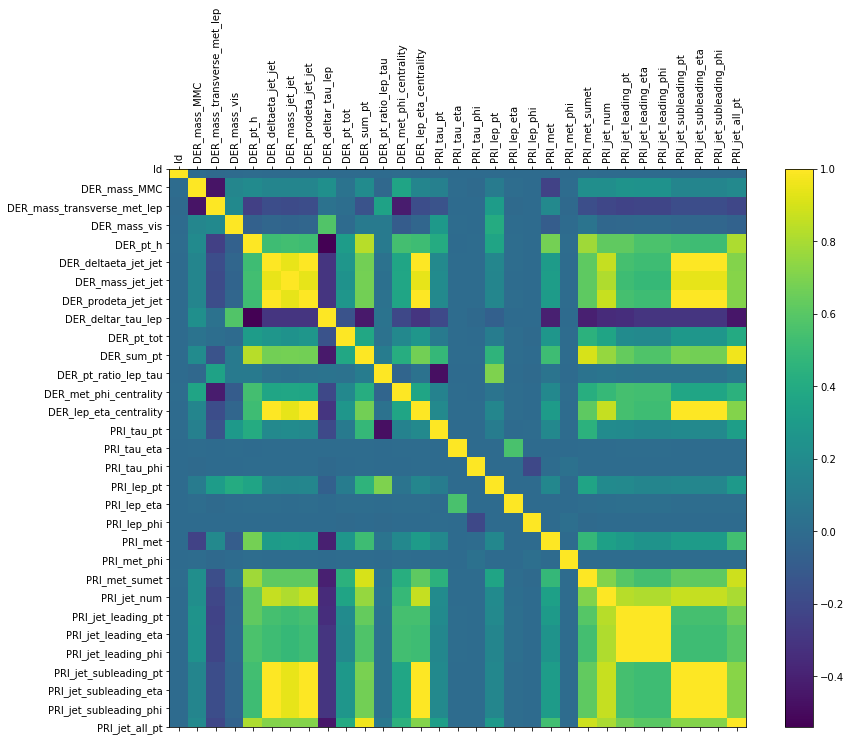

In [91]:
f = plt.figure(figsize=(14, 10))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns)
cb = plt.colorbar()

### Get the most important features

Feature: 0, Score: 0.00007
Feature: 1, Score: -0.00714
Feature: 2, Score: -0.00624
Feature: 3, Score: -0.00048
Feature: 4, Score: -0.00308
Feature: 5, Score: 0.00045
Feature: 6, Score: -0.02382
Feature: 7, Score: 0.34216
Feature: 8, Score: -0.00011
Feature: 9, Score: -2.84184
Feature: 10, Score: -0.21622
Feature: 11, Score: 0.09554
Feature: 12, Score: 0.04520
Feature: 13, Score: 2.85041
Feature: 14, Score: -0.00026
Feature: 15, Score: -0.00100
Feature: 16, Score: 2.85488
Feature: 17, Score: -0.00035
Feature: 18, Score: 0.00085
Feature: 19, Score: 0.00369
Feature: 20, Score: 0.00022
Feature: 21, Score: -0.00050
Feature: 22, Score: -0.21152
Feature: 23, Score: -0.00022
Feature: 24, Score: 0.00020
Feature: 25, Score: 0.00034
Feature: 26, Score: -0.00007
Feature: 27, Score: -0.00658
Feature: 28, Score: -0.01183
Feature: 29, Score: 2.84109


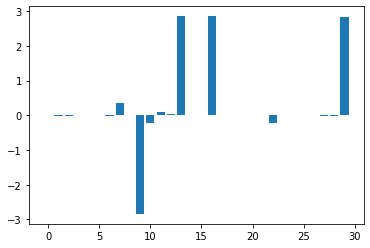

In [92]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

model = LinearRegression()
model.fit(tX, y)
importance_score = model.coef_
for i,j in enumerate(importance_score):
    print('Feature: %0d, Score: %.5f' % (i,j))
pyplot.bar([x for x in range(len(importance_score))], importance_score)
pyplot.show()

Visualize feature correlation

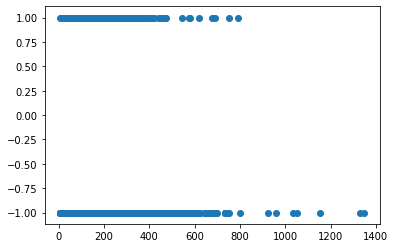

In [93]:
x = data['DER_mass_vis'] #enter any feature to check for correlation to label.
plt.scatter(x, y) 
plt.plot()
plt.show()

Visualization of the predictions to show if the data set is balanced. Since we have a slightly unbalanced dataset we will evaluate the performance with the F1-Score which is a more telling method for evaluation.

Ratio: 0.521


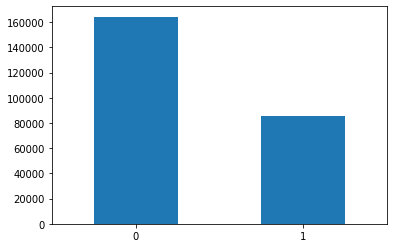

In [94]:
count = collections.Counter(y)
balance = [count[-1], count[1]]
vis = pd.Series(balance, index=range(len(balance)))
vis.plot(kind="bar", rot=0)
plt.plot()
print("Ratio:", round(count[1]/count[-1],3))

## Scoring functions

In [25]:
def f1_score(y_valid, tX_valid, weights):
    """
    Return the F1-score achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for 'Precision and recall'
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for 'F-score'
        https://en.wikipedia.org/wiki/F-score

    """

    y_pred = predict_labels(weights, tX_valid) # Obtaining the predictions

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))
    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)
    f1 = np.round(2 * precision * recall / (precision + recall), 4)
    return f1

In [26]:
def accuracy(y_valid, tX_valid, weights):
    """
    Return the accuracy achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    acc : float
        Accuracy for this configuration (the closer to 1 the better)

    References
    ----------
    [3] Wikipedia entry for 'Accuracy and precision'
        https://en.wikipedia.org/wiki/Accuracy_and_precision

    """

    y_pred = predict_labels(weights, tX_valid) # Obtaining the predictions
    num_tp_tn = np.sum(y_valid == y_pred) # Calculating number of true positives and negatives
    acc = np.round(num_tp_tn / len(y_valid), 4)
    return acc

## Hyperparameter tuning

In [27]:
def cross_validate(regressor, y, tX, param, k_fold, score='f1'):    
    """
    'k_fold' cross validate a regressor with parameters 'param', data '(y, TX)' 
    and score the predictions with 'score'

    Parameters
    ----------
    regressor : String
        String that defines which regressor to use
    y : np.ndarray
        Vector with the labels.
    tX : np.ndarray
        Array with the samples as rows and the features as columns.
    param : np.ndarray
        Parameters on weight, gamma and max_iterations
    k_fold : Integer
        Integer that defines how many folds to make
    score : float
        Float of a given performance score (e.g. f1)

    Returns
    -------
    mean : float
    std : float

    """

    fold_size = int(len(y) / k_fold)
    scores = []
    rand_ind = np.random.permutation(np.arange(len(y)))
    for k in range(k_fold):
        valid_ind = rand_ind[k*fold_size:(k+1)*fold_size] # Splitting data set into validation and training set (for current fold)
        tX_train, y_train = tX[valid_ind], y[valid_ind]
        tX_valid, y_valid = np.delete(tX, valid_ind, axis=0), np.delete(y, valid_ind, axis=0)
        weights, _ = eval(regressor)(y_train, tX_train, **param) # Fitting/scoring regressor with the tarining/validation set
        if score == 'f1': # Scoring according to the scoring criterion
            scores.append(f1_score(y_valid, tX_valid, weights))
        else:
            scores.append(accuracy(y_valid, tX_valid, weights))
    return np.mean(scores), np.std(scores, ddof=1)

In [28]:
def best_parameters(regressor, y, tX, params, k_fold, score):
    
    """
    Find best parameters from a list of parameters with k_fold cross validation.

    Parameters
    ----------
    regressor : String
        String that defines which regressor to use
    y : np.ndarray
        Vector with the labels.
    tX : np.ndarray
        Array with the samples as rows and the features as columns.
    param : np.ndarray
        Parameters on weight, gamma and max_iterations
    k_fold : Integer
        Integer that defines how many folds to make
    score : float
        Float of a given performance score (e.g. f1)

    """

    max_std_score = 0.0
    max_mean_score = 0.0
    max_param = {}
    for param in params:
        mean_score, std_score = cross_validate(regressor, y, tX, param, k_fold, score)
        if mean_score > max_mean_score: # Checking for the best score
            max_mean_score = mean_score
            max_std_score = std_score
            max_param = param
    max_gammas.append(max_param["gamma"])
    max_scores.append(max_mean_score)
    max_iters.append(max_param["max_iters"])
    print("Best parameter set for '", regressor, "' was:")
    print("param = ", max_param)
    print("Mean ", score, " score: ", max_mean_score, " +/- ", max_std_score)

In [24]:
max_gammas = []
max_scores = []
max_iters = []

### Gradient descent

In [30]:
for degree in range(1, 2):
    tX_poly = polynomial_basis(tX, range(1, degree+1), std=True)
    print("Result for degree ", degree)
    params = [{'initial_w': np.ones(tX_poly.shape[1]), 'max_iters': max_iters, 'gamma': gamma}
        for gamma, max_iters in zip(np.linspace(0.02, 0.1, 5), np.linspace(1000, 5000, 5, dtype=int))]
    best_parameters('least_squares_GD', y, tX_poly, params, k_fold=4, score='f1')
    print("---------------------------------------------------")

Result for degree  1
Best parameter set for ' least_squares_GD ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 1000, 'gamma': 0.02}
Mean  f1  score:  0.665  +/-  0.0014854853303438386
---------------------------------------------------


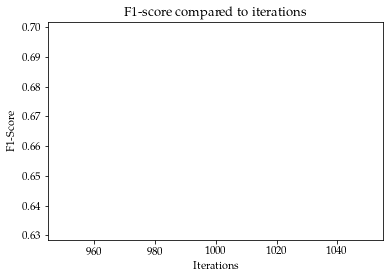

In [31]:
plt.plot(max_iters, max_scores)
plt.title("F1-score compared to iterations") 
plt.xlabel('Iterations')
plt.ylabel('F1-Score')
plt.show()

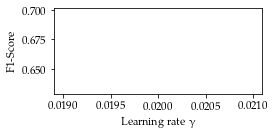

In [33]:
plt.plot(max_gammas, max_scores)
plt.title("F1-score compared to gamma") 
plt.xlabel('Gamma')
plt.ylabel('F1-Score')
plt.show()

In [39]:
plt.figure(figsize=(9.5*cm, 8*cm))

gammas = np.logspace(-7, -3, 5)
lambdas = np.logspace(-7, -3, 5)

f1 = np.frompyfunc(lambda a, b: cross_validate('reg_logistic_regression', y, tX,
        {'lambda_' : a, 'gamma': b}, 4, 'f1'), 2, 2).outer(gammas, lambdas)

<Figure size 269.291x226.772 with 0 Axes>

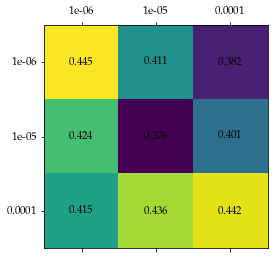

In [55]:
mean, std = f1
plt.matshow(mean.astype(np.float))
plt.yticks(range(len(gammas)), gammas)
plt.xticks(range(len(lambdas)), lambdas)
plt.ylabel(r'Learning rate $\gamma$')
plt.xlabel(r'Regularization $\lambda$')

for (i, j), z in np.ndenumerate(mean):
    plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')

In [ ]:

plt.plot(max_gammas, max_scores, color=color_theme)
#plt.title("F1-score compared to gamma") 
plt.xlabel(r'Learning rate $\gamma$')
plt.ylabel('F1-Score')

plt.savefig('report/figures/F1_gamma.pgf', bbox_inches='tight')

### Stochastic gradient descent

In [68]:
for degree in range(1, 8):
    tX_poly = polynomial_basis(tX, range(1, degree+1), std=True)
    print("Result for degree ", degree)
    params = [{'initial_w': np.ones(tX_poly.shape[1]), 'max_iters': max_iters, 'gamma': gamma}
        for gamma, max_iters in zip(np.linspace(0.001, 0.1, 100), np.linspace(1000, 10000, 10, dtype=int))]
    best_parameters('least_squares_SGD', y, tX_poly, params, k_fold=4, score='f1')
    print("---------------------------------------------------")

Result for degree  1
Best parameter set for ' least_squares_SGD ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 10000, 'gamma': 0.010000000000000002}
[Mean  f1  score:  0.45667499999999994  +/-  0.0005123475382979669
---------------------------------------------------
Result for degree  2
Best parameter set for ' least_squares_SGD ' was:
param =  {'initial_w': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'max_iters': 1000, 'gamma': 0.001}
[Mean  f1  score:  0.404675  +/-  0.0005909032633745411
---------------------------------------------------
Result for degree  3
Best parameter set for ' least_squares_SGD ' was:
param =  {'initial_w':

### Least squares

In [71]:
for degree in range(1, 8):
    tX_poly = polynomial_basis(tX, range(1, degree+1), std=True)
    print("Result for degree ", degree)
    print(cross_validate('least_squares', y, tX_poly, {}, k_fold=4, score='f1'))
    print("---------------------------------------------------")

Result for degree  1
(0.6648, 0.0009486832980505146)
---------------------------------------------------
Result for degree  2
(0.6798500000000001, 0.0007724420150837417)
---------------------------------------------------
Result for degree  3
(0.6807, 0.0038635044540761957)
---------------------------------------------------
Result for degree  4
(0.6706, 0.01487884404112091)
---------------------------------------------------
Result for degree  5
(0.6873, 0.014738385257551096)
---------------------------------------------------
Result for degree  6
(0.69045, 0.0042154477816715875)
---------------------------------------------------
Result for degree  7
(0.6754749999999999, 0.03813016085288213)
---------------------------------------------------


### Ridge regressor

In [27]:
params = [{'lambda_': lambda_} for lambda_ in np.linspace(0.001, 0.01, 3)]
for degree in range(3, 5):
    tX_poly = polynomial_basis(tX, range(1, degree+1), std=True)
    print("Result for degree ", degree)
    best_parameters('ridge_regression', y, tX_poly, params, k_fold=4, score='acc')
    print("---------------------------------------------------")

Result for degree  3
New thresh 0.01
New thresh 0.02
New thresh 0.03
New thresh 0.04
New thresh 0.05
New thresh 0.060000000000000005
New thresh 0.07
New thresh 0.08
New thresh 0.09
New thresh 0.09999999999999999
New thresh 0.10999999999999999
New thresh 0.11999999999999998
New thresh 0.12999999999999998
New thresh 0.13999999999999999
New thresh 0.15
New thresh 0.16
New thresh 0.17
New thresh 0.18000000000000002
New thresh 0.19000000000000003
New thresh 0.20000000000000004
New thresh 0.21000000000000005
New thresh 0.22000000000000006
New thresh 0.01
New thresh 0.02
New thresh 0.03
New thresh 0.04
New thresh 0.05
New thresh 0.060000000000000005
New thresh 0.07
New thresh 0.08
New thresh 0.09
New thresh 0.09999999999999999
New thresh 0.10999999999999999
New thresh 0.11999999999999998
New thresh 0.12999999999999998
New thresh 0.13999999999999999
New thresh 0.15
New thresh 0.16
New thresh 0.17
New thresh 0.18000000000000002
New thresh 0.19000000000000003
New thresh 0.20000000000000004
New t

### Logistic regressor

In [199]:
params = [{'initial_w': np.ones(tX.shape[1]), 'max_iters': max_iters, 'gamma': gamma}
        for gamma, max_iters in zip(np.linspace(0.001, 0.01, 10), np.linspace(100, 10000, 100, dtype=int))]
print(len(params))
best_parameters('logistic_regression', y, tX, params, k_fold=4, score='acc')

10


KeyboardInterrupt: 

### Regularized logistic regressor

In [200]:
params = [{'lambda_' : lambda_, 'initial_w': np.ones(tX.shape[1]), 'max_iters': max_iters, 'gamma': gamma}
        for lambda_, gamma, max_iters in zip(np.linspace(0.01, 0.1, 10), np.linspace(0.01, 0.1, 10), np.linspace(100, 1000, 10, dtype=int))]
best_parameters('reg_logistic_regression', y, tX, params, k_fold=4, score='f1')

KeyboardInterrupt: 

## Regressors

### 1. Least squares gradient descent

In [50]:
# Hyperparameters
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 1300
gamma = 0.013

# Fitting
start = time.time()
weights, loss = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_GD': F1 = ", f1)
print("Accuracy achieved with 'least_squares_GD': accuracy = ", acc)

Execution time: 24.416 sec
F1-score achieved with 'least_squares_GD': F1 =  nan
Accuracy achieved with 'least_squares_GD': accuracy =  0.0


<ipython-input-48-f82cca3d8eec>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision = num_tp / (num_tp + num_fp)
<ipython-input-48-f82cca3d8eec>:35: RuntimeWarning: invalid value encountered in long_scalars
  recall = num_tp / (num_tp + num_fn)


 ### 2. Least squares stochastic gradient descent

In [220]:
# Hyperparameters
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 9800
gamma = 0.098

# Fitting
start = time.time()
weights, loss = least_squares_SGD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares_SGD': F1 = ", f1)
print("Accuracy achieved with 'least_squares_SGD': accuracy = ", acc)

Execution time: 0.1326 sec
F1-score achieved with 'least_squares_SGD': F1 =  0.4578
Accuracy achieved with 'least_squares_SGD': accuracy =  0.5981


### 3. Least squares (normal equation)

In [221]:
# Fitting
start = time.time()
weights, loss = least_squares(y_train, tX_train)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'least_squares': F1 = ", f1)
print("Accuracy achieved with 'least_squares': accuracy = ", acc)

Execution time: 0.0555 sec
F1-score achieved with 'least_squares': F1 =  0.5537
Accuracy achieved with 'least_squares': accuracy =  0.6826


### 4. Ridge regression (for least square normal equation)

In [8]:
# Hyperparameters
lambda_ = 0.0051

# Fitting
start = time.time()
weights, loss = ridge_regression(y_train, tX_train_binary, lambda_)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid_binary, weights)
acc = accuracy(y_valid, tX_valid_binary, weights)
print("F1-score achieved with 'ridge_regression': F1 = ", f1)
print("Accuracy achieved with 'ridge_regression': accuracy = ", acc)

Execution time: 0.016 sec


NameError: name 'f1_score' is not defined

### 5. Logistic regression

In [223]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = logistic_regression(y, tX, initial_w, max_iters, gamma)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)
print("Accuracy achieved with 'logistic_regression': accuracy = ", acc)

Execution time: 17.0299 sec
F1-score achieved with 'logistic_regression': F1 =  0.4098
Accuracy achieved with 'logistic_regression': accuracy =  0.6268


### 5: Logistic regression (alternative)

In [186]:
def calculate_sigmoid(z):
    return 1/(1 + np.exp(-z))

In [187]:
def calculate_cost(y, tX, w):
    return 1/2 * np.sum((y-calculate_sigmoid(np.dot(tX, w)))**2)

In [188]:
def calculate_gradient(y, tX, w):   
    return np.dot(y-calculate_sigmoid(np.dot(tX, w)), tX)

In [225]:
def logistic_regression_alt(y, tX, initial_w, max_iters=100, gamma=0.01):
    w = initial_w
    loss = []
    for i in range(max_iters):
        random =  np.random.randint(0, len(y))
        w = w + gamma * calculate_gradient(y[random], tX[random], w)
        cost = calculate_cost(y, tX, w)
        loss.append(cost)
    return w, loss

In [226]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = logistic_regression_alt(y, tX, initial_w, max_iters, gamma)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'logistic_regression_alt': F1 = ", f1)
print("Accuracy achieved with 'logistic_regression_alt': accuracy = ", acc)

/Users/olivierstaehli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Execution time: 3.7094 sec
F1-score achieved with 'logistic_regression_alt': F1 =  0.4098
Accuracy achieved with 'logistic_regression_alt': accuracy =  0.6268


### 6. Regularized logistic regression

In [224]:
# Hyperparameters
# TODO: test different values of gamma and lambda
lambda_ = 1
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 100
gamma = 0.01

# Fitting
start = time.time()
weights, loss = reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'reg_logistic_regression': F1 = ", f1)
print("Accuracy achieved with 'reg_logistic_regression': accuracy = ", acc)

Execution time: 12.0833 sec
F1-score achieved with 'reg_logistic_regression': F1 =  0.4046
Accuracy achieved with 'reg_logistic_regression': accuracy =  0.3732


## Preprocessing testing

In [80]:
lambda_ = 0.001
for key in train_dict:
    weights, loss = ridge_regression(y_train, train_dict[key], lambda_)
    f1 = f1_score(y_valid, valid_dict[key], weights)
    acc = accuracy(y_valid, valid_dict[key], weights)
    print("F1-score achieved with 'ridge_regression', dataset ", key, " : F1 = ", f1)
    print("Accuracy achieved with 'ridge_regression', dataset ", key, " : accuracy = ", acc)

F1-score achieved with 'ridge_regression', dataset  normal  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  normal  : accuracy =  0.718
F1-score achieved with 'ridge_regression', dataset  zeros  : F1 =  0.6658
Accuracy achieved with 'ridge_regression', dataset  zeros  : accuracy =  0.7192
F1-score achieved with 'ridge_regression', dataset  mean  : F1 =  0.6652
Accuracy achieved with 'ridge_regression', dataset  mean  : accuracy =  0.7194
F1-score achieved with 'ridge_regression', dataset  median  : F1 =  0.6652
Accuracy achieved with 'ridge_regression', dataset  median  : accuracy =  0.7197
F1-score achieved with 'ridge_regression', dataset  binary  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  binary  : accuracy =  0.7182
F1-score achieved with 'ridge_regression', dataset  deleted  : F1 =  0.6595
Accuracy achieved with 'ridge_regression', dataset  deleted  : accuracy =  0.7069


## Optimized Regressors

In [193]:
def f1_score_predictions(y_valid, y_pred):
    """
    Return the F1-score achieved with the predictions of a validation set
    
    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    y_pred : np.ndarray
        Vector containing the predictions.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for the Precision and recall
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for F-score
        https://en.wikipedia.org/wiki/F-score

    """

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))

    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)
    f1 = np.round(2 * precision * recall / (precision + recall),4)
    return f1

### Ensemble learner 1

In [194]:
def ensemble_learner1(y, tX, tX_valid, n_learners=10, ratio=0.5):
    """
    Supply 'n_learners' regressors with a random subset of size 'ratio' of the
    features. Majority vote for the prediction.
    """

    y_pred_final = np.zeros(len(y_valid))
    n_features = tX.shape[1]

    for i in range(n_learners):

        feature_indices = np.random.choice(np.arange(n_features), int(ratio*n_features))
        tX_slice = tX[:, feature_indices]
        weights, _ = reg_logistic_regression(y, tX_slice, 1, np.ones(tX_slice.shape[1], dtype=float), 100, 0.01)

        tX_valid_slice = tX_valid[:, feature_indices]
        y_pred = tX_valid_slice @ weights
        y_pred[np.where(y_pred <= 0)] = -1
        y_pred[np.where(y_pred > 0)] = 1

        y_pred_final += y_pred

    y_pred_final[np.where(y_pred_final <= 0)] = -1
    y_pred_final[np.where(y_pred_final > 0)] = 1

    return y_pred_final

In [195]:
# Fitting
start = time.time()
y_pred = ensemble_learner1(y, tX, tX_valid, n_learners=10, ratio=0.3)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score_predictions(y_valid, y_pred)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)

Execution time: 19.3938 sec
F1-score achieved with 'logistic_regression': F1 =  0.4046


### Ensemble learner 2

In [196]:
def ensemble_learner2(y, tX, tX_valid, n_learners=10, ratio=0.5):
    """
    Supply 'n_learners' regressors with a random subset of size 'ratio' of the
    samples. Majority vote for the prediction.
    """

    y_pred_final = np.zeros(len(y_valid))
    n_samples = tX.shape[0]

    for i in range(n_learners):

        sample_indices = np.random.choice(np.arange(n_samples), int(ratio*n_samples))
        tX_slice = tX[sample_indices, :]
        y_slice = y[sample_indices]
        weights, _ = reg_logistic_regression(y_slice, tX_slice, 1, np.ones(tX_slice.shape[1], dtype=float), 100, 0.01)

        y_pred = tX_valid @ weights
        y_pred[np.where(y_pred <= 0)] = -1
        y_pred[np.where(y_pred > 0)] = 1

        y_pred_final += y_pred

    y_pred_final[np.where(y_pred_final <= 0)] = -1
    y_pred_final[np.where(y_pred_final > 0)] = 1

    return y_pred_final

In [197]:
# Fitting
start = time.time()
y_pred = ensemble_learner2(y, tX, tX_valid, n_learners=100, ratio=0.1)
exec_time = round(time.time()-start, 4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score_predictions(y_valid, y_pred)
print("F1-score achieved with 'logistic_regression': F1 = ", f1)

Execution time: 26.6123 sec
F1-score achieved with 'logistic_regression': F1 =  0.4046


### Evaluation

In [198]:
y_pred = predict_labels(weights, tX_valid)
confusion_matrix(y_valid, y_pred)

ValueError: shapes (200000,30) and (41,) not aligned: 30 (dim 1) != 41 (dim 0)

## Lasso subgradient descent regressor

In [ ]:
def lasso_SD(y, tX, initial_w, max_iters=1000, gamma=0.1, lambda_ = 0.1, threshold=None):

    # Number of samples
    N = len(y)

    # Converting 1D arrays to 2D arrays
    w = initial_w.reshape((len(initial_w), 1))
    y = y.reshape((N, 1))

    # Checking if 'tX' is a 1D array, and consequently converting to a 2D array
    if len(tX.shape) == 1:

        tX = tX.reshape((N, 1))

    for iter in range(max_iters):

        # Error vector
        e = y - np.dot(tX, w)

        # Subgradient for the Lasso loss function
        subgrad = - np.dot(tX.T, e) / N + lambda_ / np.sqrt(1 + iter) * np.sign(w)

        # Updating weights with negative gradient scaled by 'gamma'
        w = w - gamma * subgrad


    # Computing loss (MSE) for the weights in the final iteration
    loss = np.mean(e**2) / 2

    # Converting weights back to 1D arrays
    w = w.reshape(len(w))

    # Setting to zero all the entries of w under the threshold in absolute value
    if (threshold != None):
        w[np.absolute(w) < threshold] = 0

    return w, loss

In [ ]:
# Hyperparameters
# TODO: test different values of gamma and lambda
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 500
gamma = 0.1
lambda_ = 0.01
threshold = 0.005

# Fitting and scoring WITHOUT threshold
start = time.time()
weights, loss = lasso_SD(y_train, tX_train, initial_w, max_iters, gamma, lambda_)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))
print(weights)
print(np.sort(abs(weights)))

f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'lasso_GD', no threshold: F1 = ", f1)
print("Accuracy achieved with 'lasso_GD', no threshold: accuracy = ", acc, "\n\n")

# Fitting and scoring WITH threshold
start = time.time()
weights_thresh, loss_thresh = lasso_SD(y_train, tX_train, initial_w, max_iters, gamma, lambda_, threshold)

exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))
print(weights_thresh)
f1 = f1_score(y_valid, tX_valid, weights_thresh)
acc = accuracy(y_valid, tX_valid, weights_thresh)
print("F1-score achieved with 'lasso_GD', with threshold: F1 = ", f1)
print("Accuracy achieved with 'lasso_GD', with threshold: accuracy = ", acc, "\n\n")

# Adding a polynomial basis of all the features
degree = 7
poly_tX_tr = standardize(polynomial_basis(tX_train, degree))
poly_tX_va = standardize(polynomial_basis(tX_valid, degree))
initial_w = np.zeros(poly_tX_tr.shape[1])

start = time.time()
weights_poly, loss_poly = lasso_SD(y_train, poly_tX_tr, initial_w, max_iters, gamma, lambda_)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))
#print(weights_poly)
f1 = f1_score(y_valid, poly_tX_va, weights_poly)
acc = accuracy(y_valid, poly_tX_va, weights_poly)
print("F1-score achieved with 'lasso_GD', polynomial basis: F1 = ", f1)
print("Accuracy achieved with 'lasso_GD', polynomial basis: accuracy = ", acc)



## Mean Absolute Error subgradient regressor

In [ ]:
def absolute_SD(y, tX, initial_w, max_iters=100, gamma=0.1):

    # Number of samples
    N = len(y)

    # Converting 1D arrays to 2D arrays
    w = initial_w.reshape((len(initial_w), 1))
    y = y.reshape((N, 1))

    # Checking if 'tX' is a 1D array, and consequently converting to a 2D array
    if len(tX.shape) == 1:

        tX = tX.reshape((N, 1))

    for iter in range(max_iters):

        # Error vector
        e = y - np.dot(tX, w)

        # Subgradient for the MAE loss function
        subgrad = - np.dot(tX.T, np.sign(e)) / N

        # Updating weights with negative gradient scaled by 'gamma'
        w = w - gamma * subgrad


    # Computing loss (MSE) for the weights in the final iteration
    loss = np.mean(np.abs(e))

    # Converting weights back to 1D arrays
    w = w.reshape(len(w))

    return w, loss

In [ ]:
# Hyperparameters
# TODO: test different values of gamma
initial_w = np.ones(tX_train.shape[1], dtype=float)
max_iters = 500
gamma = 0.1

# Fitting
start = time.time()
weights, loss = absolute_SD(y_train, tX_train, initial_w, max_iters, gamma)
exec_time = round(time.time()-start,4)
print('Execution time: {} sec'.format(exec_time))

# Scoring
f1 = f1_score(y_valid, tX_valid, weights)
acc = accuracy(y_valid, tX_valid, weights)
print("F1-score achieved with 'absolute_SD': F1 = ", f1)
print("Accuracy achieved with 'absolute_GD': accuracy = ", acc)

## Generate predictions and save ouput in csv format for submission

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

OSError:  not found.

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)